In [2]:
import numpy as np
import pandas as pd
import re
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.models import model_from_json


In [3]:
jsonpath = "Dataset for Detection of Cyber-Trolls.json"
csvpath =  "CyberBullyingTypesDataset.csv"  
pickle_model_path = "BI LSTM/models/model.pkl"
keras_model_path = "BI LSTM/models/model.keras"

In [11]:

cleaned_df = pd.read_csv("cleaned_dataset.csv")
texts = cleaned_df['texts'].tolist()
combined_labels = cleaned_df['label'].tolist()

In [12]:
cleaned_df['label'].value_counts()


label
1    26781
0    19440
Name: count, dtype: int64

In [13]:
cleaned_df.head(5)

,texts,label
0,get fucking real dude,1
1,she is as dirty as they come and that crook re...,1
2,why did you fuck it up i could do it all day t...,1
3,dude they dont finish enclosing the fucking sh...,1
4,wtf are you talking about men no men thats not...,1


**BI-LSTM MODEL**

In [14]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

max_length = 100 
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(combined_labels)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

In [15]:
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)
train_label_counts = y_train_series.value_counts()
test_label_counts = y_test_series.value_counts()
print("Training set label counts:")
print(train_label_counts)
print("Testing set label counts:")
print(test_label_counts)

Training set label counts:
1    21445
0    15531
Name: count, dtype: int64
Testing set label counts:
1    5336
0    3909
Name: count, dtype: int64


In [28]:


model = Sequential([
    Embedding(input_dim=45405, output_dim=128),  
    Bidirectional(LSTM(128, return_sequences=True)),  
    Dropout(0.5),
    Bidirectional(LSTM(64)),  
    Dropout(0.5),
    Dense(128, activation='relu'),  
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test)) 


Epoch 1/10
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 287s 239ms/step - accuracy: 0.8258 - loss: 0.3721 - val_accuracy: 0.8860 - val_loss: 0.2592
Epoch 2/10
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 270s 234ms/step - accuracy: 0.9077 - loss: 0.2238 - val_accuracy: 0.8912 - val_loss: 0.2590
Epoch 3/10
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 310s 268ms/step - accuracy: 0.9242 - loss: 0.1820 - val_accuracy: 0.8867 - val_loss: 0.2747
Epoch 4/10
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 286s 247ms/step - accuracy: 0.9388 - loss: 0.1479 - val_accuracy: 0.8803 - val_loss: 0.3668
Epoch 5/10
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 302s 261ms/step - accuracy: 0.9521 - loss: 0.1126 - val_accuracy: 0.8759 - val_loss: 0.3979
Epoch 6/10
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 294s 254ms/step - accuracy: 0.9591 - loss: 0.0974 - val_accuracy: 0.8666 - val_loss: 0.4924
Epoch 7/10
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 309s 267ms/step - accuracy: 0.9665 - loss: 0.0822 - val_accuracy: 0.8707 - val_loss: 0.4892
Epoch 8/10
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 307s 266ms/step - ac

In [29]:
history

In [30]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

289/289 ━━━━━━━━━━━━━━━━━━━━ 137s 477ms/step - accuracy: 0.8654 - loss: 0.7054
Test Accuracy: 86.57%


In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score


loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

y_pred = model.predict(X_test)


y_pred_labels = (y_pred > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels))


precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


289/289 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.8654 - loss: 0.7054
Test Accuracy: 86.57%
289/289 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      3909
           1       0.89      0.88      0.88      5336

    accuracy                           0.87      9245
   macro avg       0.86      0.86      0.86      9245
weighted avg       0.87      0.87      0.87      9245

Precision: 0.89
Recall: 0.88
F1 Score: 0.88


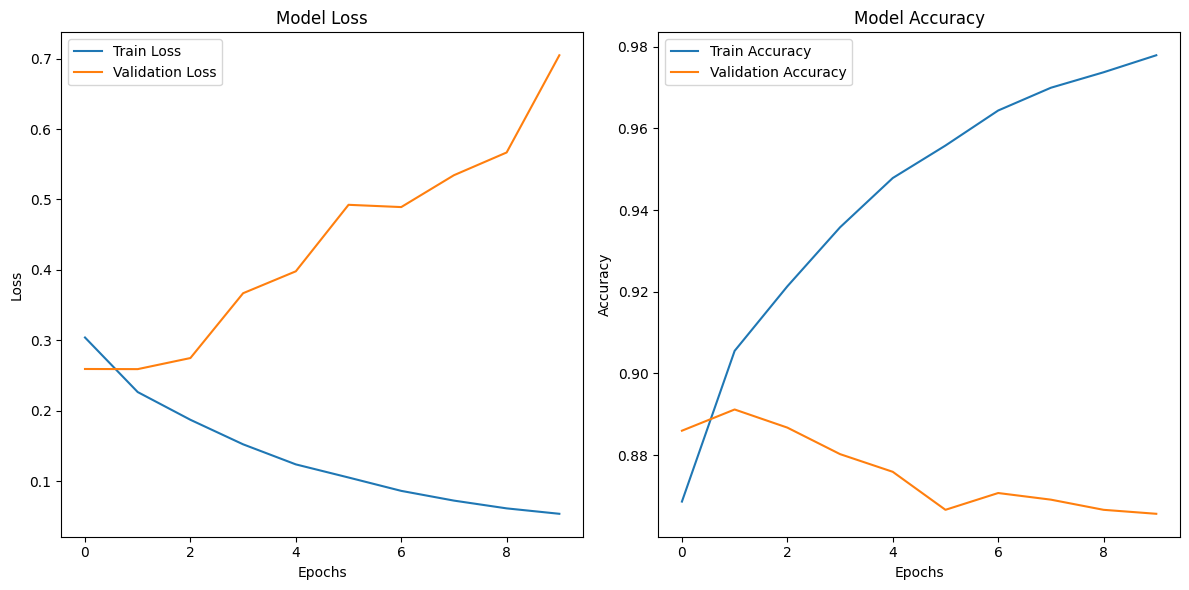

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


**Saving the Trained Model**

In [21]:
model.save(keras_model_path)
print(f"Keras model saved at: {keras_model_path}")
with open(pickle_model_path, 'wb') as f:
    pickle.dump({
        'model': model.to_json(),
        'weights': model.get_weights(),
        'tokenizer': tokenizer,
        'label_encoder': label_encoder
    }, f)
print(f"Pickle model saved at: {pickle_model_path}")


Keras model saved at: BI LSTM/models/model.keras
Pickle model saved at: BI LSTM/models/model.pkl


**Loading models**

In [22]:
model = load_model(keras_model_path)
print("Keras model loaded successfully!")
max_length = 100 


with open(pickle_model_path, 'rb') as f:
    loaded_pickle_data = pickle.load(f)

model = model_from_json(loaded_pickle_data['model'])
model.set_weights(loaded_pickle_data['weights'])

tokenizer = loaded_pickle_data['tokenizer']
label_encoder = loaded_pickle_data['label_encoder']

print("Pickle model, tokenizer, and label encoder loaded successfully!")


Keras model loaded successfully!
Pickle model, tokenizer, and label encoder loaded successfully!


**Cyberbullying Prediction**

In [34]:
def predict_bullying_and_severity(input_text):
    input_sequence = tokenizer.texts_to_sequences([input_text])
    input_padded = pad_sequences(input_sequence, maxlen=max_length, padding='post')
    bullying_prediction = model.predict(input_padded)
    print(bullying_prediction)

    if bullying_prediction >.5 and bullying_prediction < .85:
        severity = "Bullying"
        severity_level = "Moderate"  
    elif bullying_prediction > .85:
        severity = "Bullying"
        severity_level = "High"  
    else:
        severity = "Non-Bullying"
        severity_level = "Low"
    return severity, severity_level

input_comment = "bloody indian"
severity, severity_level = predict_bullying_and_severity(input_comment)

print(f"Prediction: {severity}")
print(f"Severity Level: {severity_level}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[[0.9948359]]
Prediction: Bullying
Severity Level: High
